# MNE Workflow tutorial

Tutorial: Calculating evoked potentials ans Mismatch negativity in an auditory oddball task 
1. Data preparation
    - load raw data
    - crop data
    - set eog reference
    - set eeg montage
2. Preprocessing
    - referencing
    - filter data
    - find and interpolate bad channels
    - artifact detection/repair with ICA
    - Epoching
3. Calculate evoked potentials/MMN
4. Save Data


<br/>

## Setup

<br/>

**First we'll import necessary libraries/functions**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# this allows for interactive pop-up plots
#%matplotlib qt

# allows for rendering in output-cell
%matplotlib inline


# import mne library
import mne
from mne_bids import BIDSPath, write_raw_bids, print_dir_tree, make_report, read_raw_bids

<br/>

### Data?


**This tutorial uses data from the ERP Core set collected by Kappenmann et al. {cite:p}`kappenman_erp_2021`. The ERP Core dataset contains data on a number of EEG experiments exploring different event-related and evoked potentials such as  the Error-Related Negativity (ERN (Flanker task)), the P3b (Active Visual Oddball Paradigm), or the mismatch negativity (Passive Auditory Oddball Paradigm).**


The dataset can be found on <a href="https://osf.io/thsqg/" title="ERP CORE: Contributors: Emily S. Kappenman Jaclyn Farrens Wendy Zhang Andrew X Stewart Steven J. Luck ">OSF</a>. For an explanation of the study, the EEG and ERP processing and anlysis procedures, see the <a href="https://osf.io/w3dyn/" title="OSF: ERP CORE MMN Readme.txt">Readme.txt</a> file provided by the authors.


<br/>

**We'll be using eeg data from a single subject preforming a passive auditory oddball task.** 
In this experiment subjects were presented with two tones differing in amplitude. Most of the time a "standard" tone was presented (80 dB, p = .8; ~800 trials), while a "deviant" tone was pseudo-randomly (apparently) presented some of the time (70 dB, p = .2, ~ 200 trials). In theory this violation of a learned rule (i.e. a 70 dB tone is presented in a stream of repeated 80 dB tone events) manifests in a potential called the mismatch negativity (MMN) over fronto-central electrodes, which is calculated by subtracting the response to the common (or standard) from the response to the odd (or deviant) stimuli.
The MMN is thought to reflect "the brain’s ability to perform automatic comparisons between consecutive stimuli and provides an electrophysiological index of sensory learning and perceptual accuracy" <a href="https://www.sciencedirect.com/science/article/pii/S1388245708012686" title="ScienceDirect: The mismatch negativity: A review of underlying mechanisms">({cite:p}`garrido_mismatch_2009`; see paper for more information)</a>.



**Download the dataset**

_Now as we don't want to download multiple GB of data for a simple tutorial we'll have to download the Data by hand._

First find your home_directory

In [2]:
homedir = os.path.expanduser("~")  # find home diretory
print(homedir)

/home/michael


**1.** Create a folder called **msc_05_eeg_workflow** in your **home directory**

In [3]:
msc_05_path = os.path.join(homedir, 'msc_05_eeg_workflow')  # assemble our path
os.mkdir(msc_05_path)  # find home diretory

**2.** Create the folders **sub-21**

In [4]:
sub_21_path = os.path.join(msc_05_path, 'sub-21')
os.mkdir(sub_21_path)

**3.** Create folder **eeg**  and **derivatives** in folder **sub-21**

In [5]:
sub_21_eeg_path = os.path.join(sub_21_path, 'eeg')
os.mkdir(sub_21_eeg_path)

derivatives_path = os.path.join(sub_21_path, 'derivatives')
os.mkdir(derivatives_path)

**4.** Next, navigate to the <a href="https://osf.io/5q4xs/" title="https://osf.io/5q4xs/">OSF directory of the ERP-Core dataset containing the MMN data </a>
<br/>
    


```{figure} ../../../static/neuroscience/osf_repo.png
---
width: 600px
name: OSF
---


```

**5.** Open the **MMN Raw Data BIDS-compatible folder**

```{figure} ../../../static/neuroscience/mmn_folder.png
---
width: 600px
name: MMN Raw Data BIDS-compatible folder
---


```

**6.** Download all files for **sub_21** and move them into the local **sub-21/eeg** folder created above

```{figure} ../../../static/neuroscience/sub_21_eeg_folder.png
---
width: 600px
name: sub-21 files
---


<br/>

## 1. Data Preperation

**Import the raw data and event file for subject 21**

Using  <a href="https://mne.tools/stable/generated/mne.io.read_raw.htmls" title="https://mne.tools/stable/generated/mne.io.read_raw.htmls">mne.io.read_raw_eeglab()</a> to read our data, as the EEG data ends with **.set**. For info on EEG file types consult the MNE Introduction chapter.

In [6]:
raw = mne.io.read_raw_eeglab(sub_21_eeg_path + str(os.sep) + 'sub-021_task-MMN_eeg.set', preload=True)

Reading /home/michael/msc_05_eeg_workflow/sub-21/eeg/sub-021_task-MMN_eeg.fdt
Reading 0 ... 616447  =      0.000 ...   601.999 secs...


In [7]:
event_file = pd.read_csv(sub_21_eeg_path + str(os.sep) + 'sub-021_task-MMN_events.tsv',
           sep='\t')

<br/>

**Get a quick overview on what we're workig with**

In [8]:
event_file # contains info on duration, onset, trial_type and identity of presented events

onset  duration  sample trial_type  stim_file  value
0      10.3506       NaN   10600     STATUS        NaN      1
1      13.4941       0.1   13819   stimulus        NaN    180
2      14.1328       0.1   14473   stimulus        NaN    180
3      14.7363       0.1   15091   stimulus        NaN    180
4      15.2861       0.1   15654   stimulus        NaN    180
...        ...       ...     ...        ...        ...    ...
996   597.5869       0.1  611930   stimulus        NaN     70
997   598.1875       0.1  612545   stimulus        NaN     80
998   598.7471       0.1  613118   stimulus        NaN     80
999   599.3535       0.1  613739   stimulus        NaN     70
1000  599.9307       0.1  614330   stimulus        NaN     80

[1001 rows x 6 columns]

In [9]:
type(raw)  # data recorded with EGGLAB software

mne.io.eeglab.eeglab.RawEEGLAB

<br/>

or explanations of info stored in the raw file we use the <a href="https://mne.tools/stable/generated/mne.Info.html#mne.Info" title="mne.info">raw.info()</a> function

In [10]:
# .info function stores relevant header data
print(raw.info)
# . keys function shows the keyword we can use to access info
print(raw.info.keys())

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 1024.0 Hz
>
dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])


In [11]:
raw.info['ch_names']  # show names of channels

['FP1',
 'F3',
 'F7',
 'FC3',
 'C3',
 'C5',
 'P3',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Oz',
 'Pz',
 'CPz',
 'FP2',
 'Fz',
 'F4',
 'F8',
 'FC4',
 'FCz',
 'Cz',
 'C4',
 'C6',
 'P4',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'HEOG_left',
 'HEOG_right',
 'VEOG_lower']

<br/>

and let's take a look at the raw data in source space

Using matplotlib as 2D backend.
Opening raw-browser...


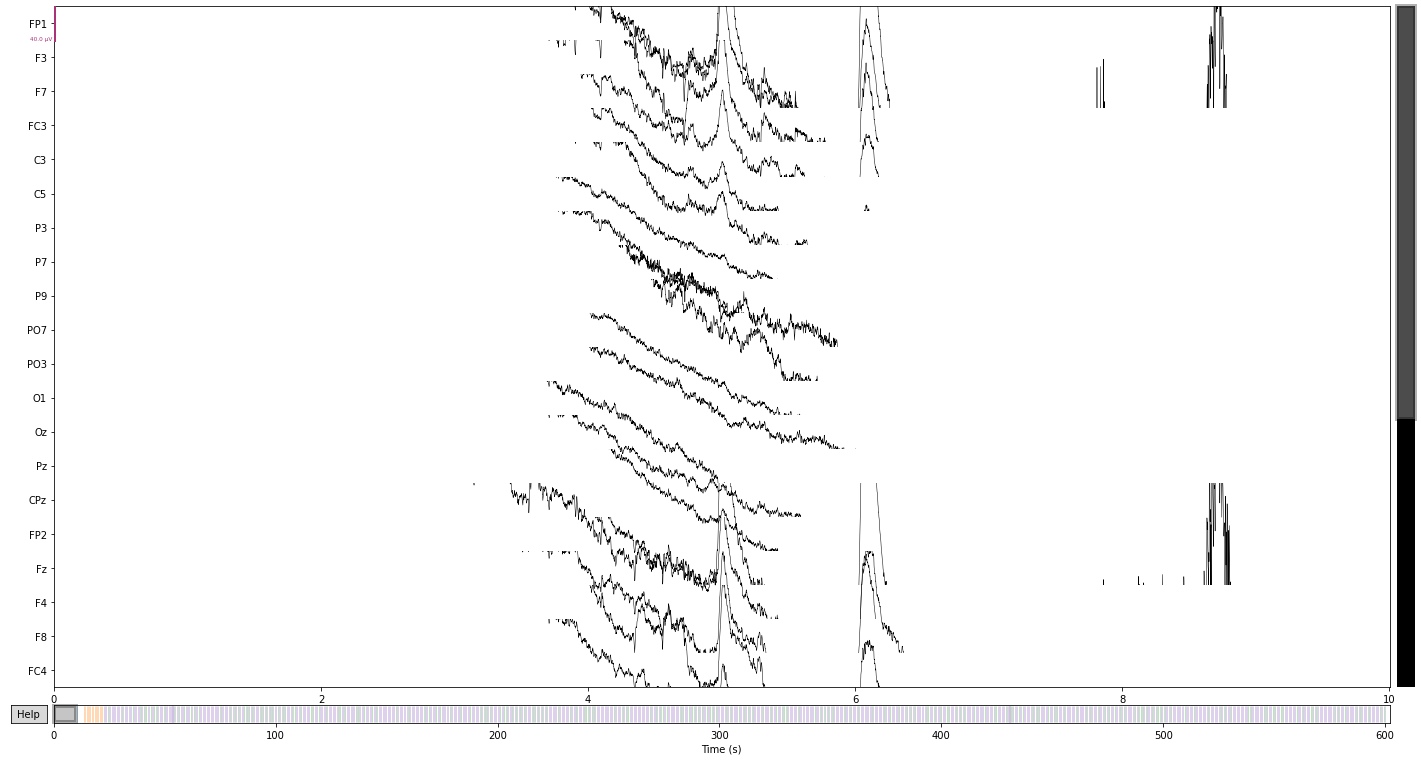

In [12]:
raw.plot();  # visualize our data

<br/>

**We can further crop or cut parts of the recording that we are not interested in or that contain artifacts, like breaks etc.**

For illustrative purposes we'll crop the data to the first event provided in our event file (signaling the start of the experiment), to avoid including irrelevant data or early artifacts (likely muscle activity related or blinks), due to the particpant getting situated. See <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.crop" title="MNE API: raw.crop()">raw.crop()</a> for possible parameters to provide.

Opening raw-browser...


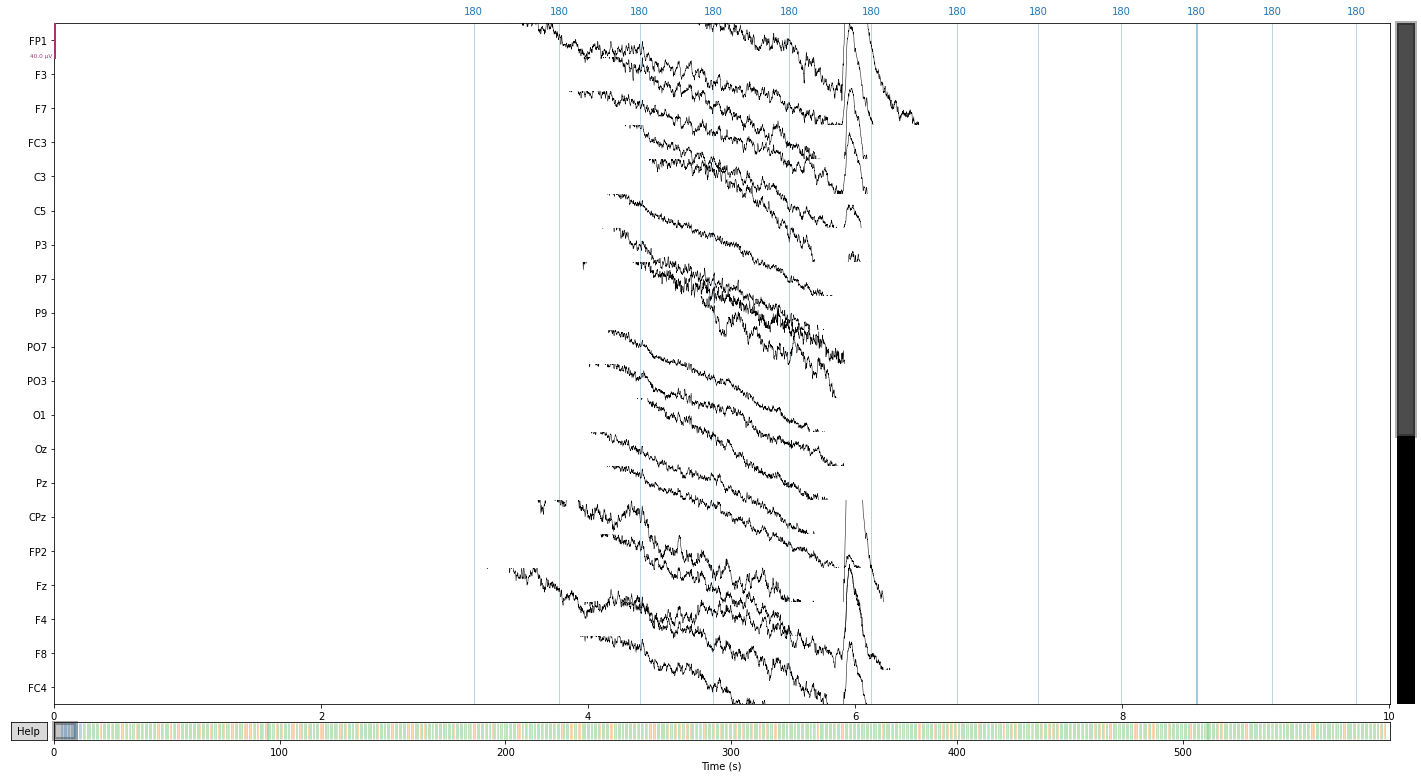

In [13]:
# choosing the entry onset column containing the "value" encoded with "1" (i.e. the start signal)
# in the event file returns the time in seconds of start signal
raw.crop(tmin=(event_file.loc[event_file['value'] == 1]['onset'][0]))
raw.plot();  # visualize our data

<br/>

**In the present study eye movement was monitored in vertical and horizontal directions via paired electrodes, therefore we have to combine these channels to recreate our eog reference electrodes using the <a href="https://mne.tools/stable/generated/mne.set_bipolar_reference.html" title="MNE API: .set_bipolar_reference">.set_bipolar_reference()</a> function**

using the electrodes:
- 'HEOG_left'
- 'HEOG_right'
- 'VEOG_lower'
- 'FP2'
 
we'll create the 2 eog channels: **VEOG & HEOG**

In [14]:
# FP1 is not included in the standard montage we'll apply shortly, as this electrode is not of interest
# for our analysis, we might as well exclude it from here on out
raw.drop_channels('FP1')

<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 32 x 605849 (591.6 s), ~147.9 MB, data loaded>

In [15]:
# bipolar electro-occulogram
mne.set_bipolar_reference(inst=raw,
                          anode='VEOG_lower',
                          cathode='FP2',
                          ch_name='VEOG',  # name of new channel
                          drop_refs=True,  # drop anode and cathode from the data
                          copy=False  # modify in-place
                         )

mne.set_bipolar_reference(inst=raw,
                          anode='HEOG_left',
                          cathode='HEOG_right',
                          ch_name='HEOG',  # name of new channel
                          drop_refs=True,  # drop anode and cathode from the data
                          copy=False  # modify in-place
                         )

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=605849
    Range : 10599 ... 616447 =     10.351 ...   601.999 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=605849
    Range : 10599 ... 616447 =     10.351 ...   601.999 secs
Ready.
Added the following bipolar channels:
HEOG


<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 30 x 605849 (591.6 s), ~138.7 MB, data loaded>

<br/>

now we'll **declare the created references as eog channels** using the <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_channel_types" title="MNE API: .set_channel_types()">.set_channel_types()</a> function.

In [16]:
raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog'} )

<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 30 x 605849 (591.6 s), ~138.7 MB, data loaded>

<br/>

A **montage describes the position of eeg electrodes on the scalp in 3d space**, if there is no montage included in your raw data  you'll have to apply one yourself using the  <a href="https://mne.tools/stable/generated/mne.channels.make_standard_montage.html" title="MNE tutorial: working with sensor locations">mne.channels.make_standard_montage()</a> function.

For more info on templates see <a href="https://mne.tools/dev/auto_tutorials/intro/40_sensor_locations.html" title="MNE tutorial: working with sensor locations">MNE: working with sensor locations </a>.

In [17]:
eeg_template_montage = mne.channels.make_standard_montage('standard_1005')

In [18]:
raw.set_montage(eeg_template_montage)  # apply montage to raw

<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 30 x 605849 (591.6 s), ~138.7 MB, data loaded>

<br/>

Now we can visualize where each of our channels is located on the scalp

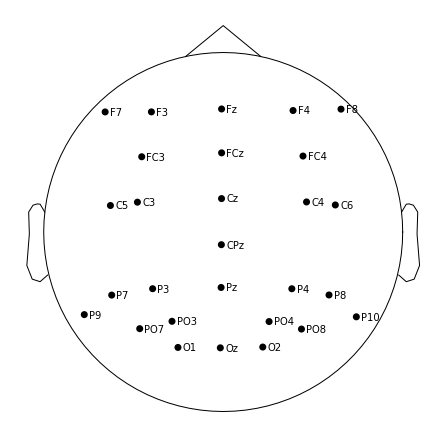

In [19]:
raw.plot_sensors(show_names=True);  # 2d

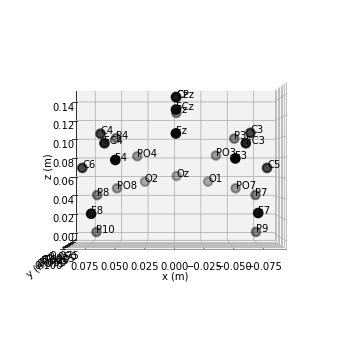

In [20]:
raw.plot_sensors(kind='3d', show_names=True);  # 3d

<br/>

## 2. Preprocessing

### Setting the eeg-reference 
**Reference electrodes should ideally capture signals that are non-brain related, but could influence our data nonetheless, i.e. environmental noise or interference** (e.g. electrical line noise)
The experimenters for the ERP-Core dataset have declared that the mastoid electrodes (P9, P10) were used as references in the supplemental info, so we'll be using these from here on out.

For more info on the advantages/disadvantages of different referencing methods see <a href="https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html" title="MNE tutorial: setting the eeg reference"> setting the eeg reference </a>

Opening raw-browser...


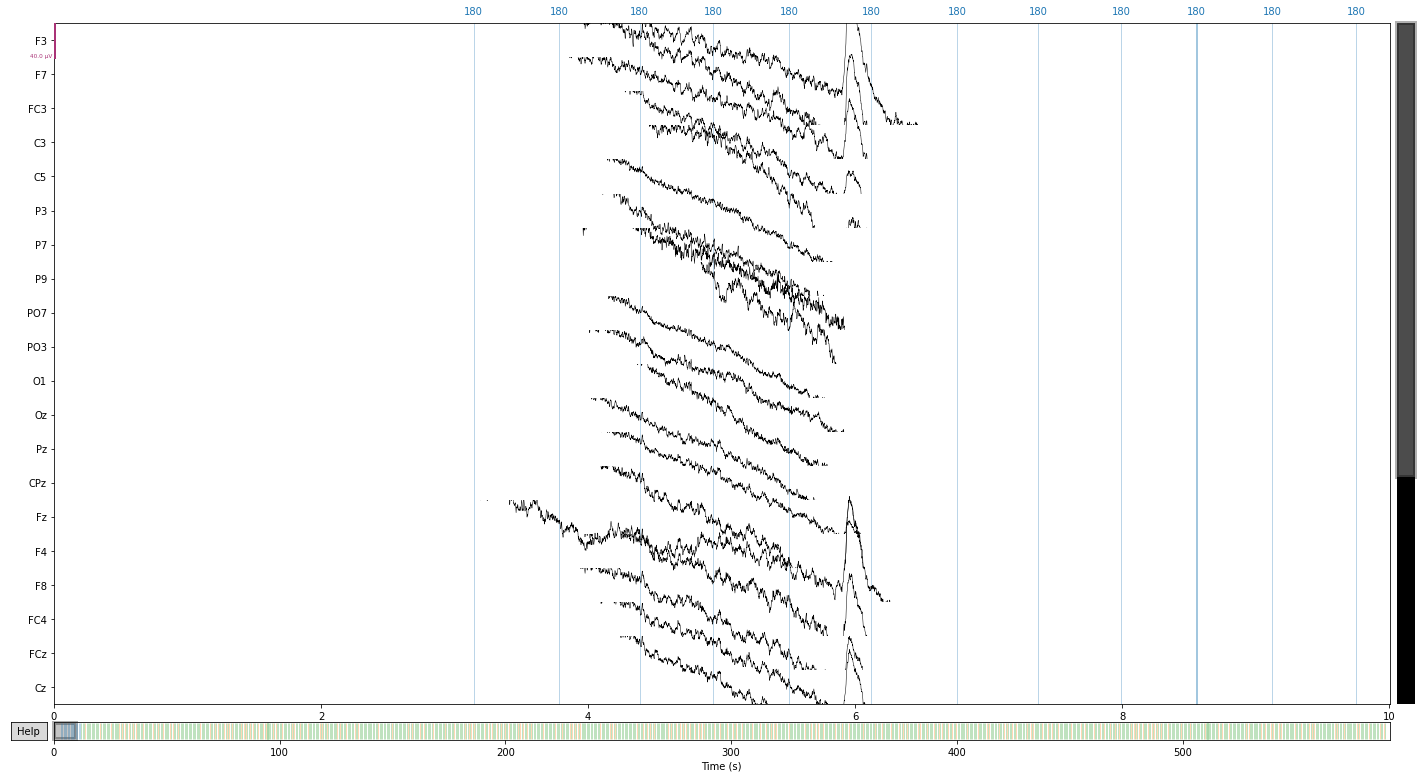

In [21]:
# let's first take a look at our raw data before applying the reference
raw.plot();

In [22]:
eeg_reference = ['P9', 'P10']  # delcare refernce electrodes as dict
raw.set_eeg_reference(ref_channels=eeg_reference)  # apply to raw

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 30 x 605849 (591.6 s), ~138.7 MB, data loaded>

<br/>

And let's compare the referenced signal

Opening raw-browser...


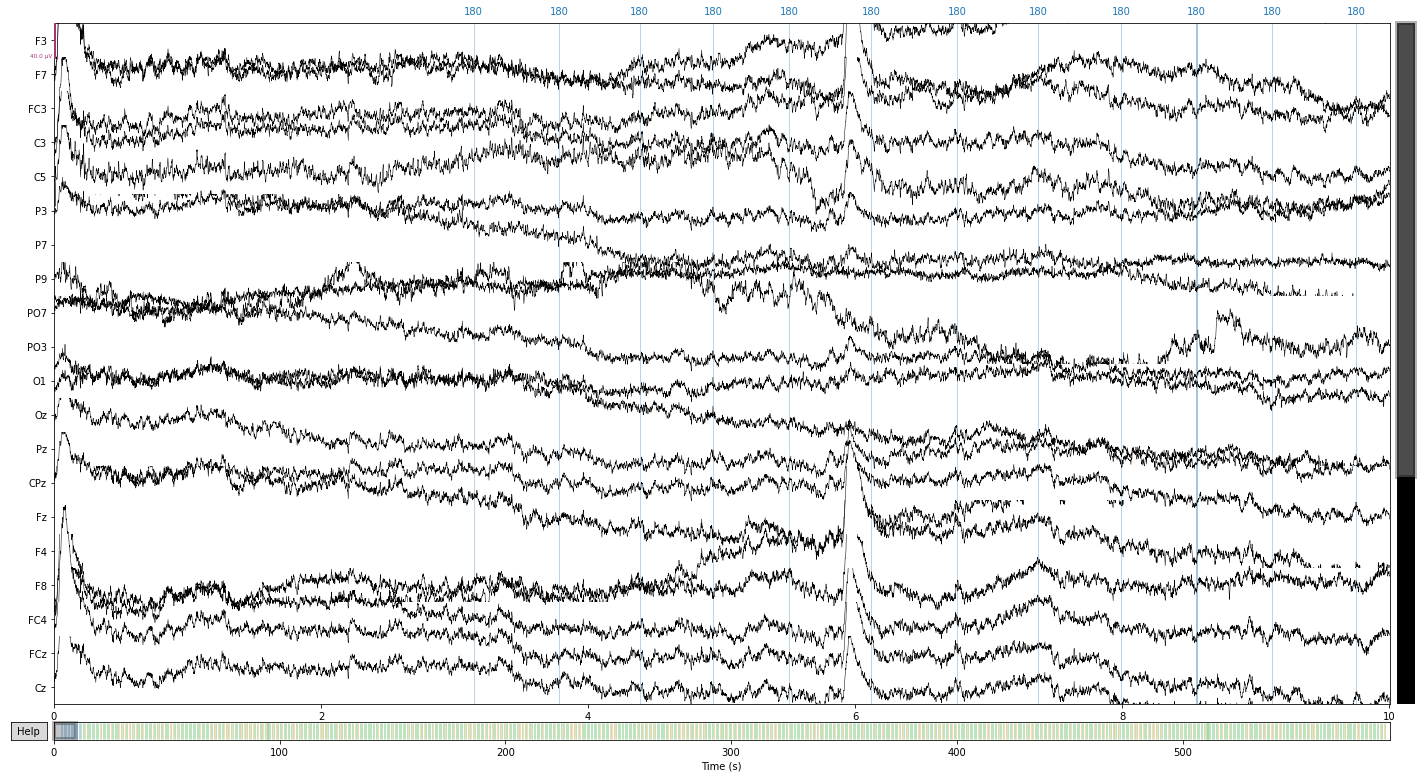

In [23]:
raw.plot();

<br/>

### Next we'll filter our signal to get rid of slow drifts and line noise

We'll be setting a highpass filter at 0.1hz (to get rid of slow drifts in electrode conductance over time) and a low-pass filter of 40hz (to get rid of electrical line noise)



In [24]:
raw_filtered = raw.copy().filter(l_freq=0.1, h_freq=40.,  # lfreq = lower cut-off frequency; hfreq =upper cut-off frequency
                 picks=['eeg', 'eog'],  # which channel to filter by type
                 filter_length='auto',
                 l_trans_bandwidth='auto',
                 h_trans_bandwidth='auto',
                 method='fir',  # finite response filter; MNE default
                 phase='zero',
                 fir_window='hamming',  # i.e. our "smoothing function" (MNE-default)
                 fir_design='firwin',
                 n_jobs=1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33793 samples (33.001 sec)



<br/>

With the <a href="https://mne.tools/stable/generated/mne.viz.plot_raw_psd.html" title="MNE API: raw.plot_psd()"> raw.plot_psd() </a> function we can visualize the power spectral density (PSD, i.e. the power as µV²/HZ in dB in the frequency domain) of of our signal for each channel before and after a filter was applied.

So let's compare the filtered to the unfiltered psd

Effective window size : 2.000 (s)


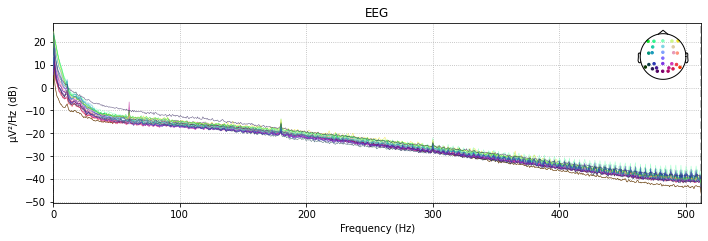

In [25]:
# unfiltered power spectral density (PSD)
raw.plot_psd(spatial_colors=True);

Effective window size : 2.000 (s)


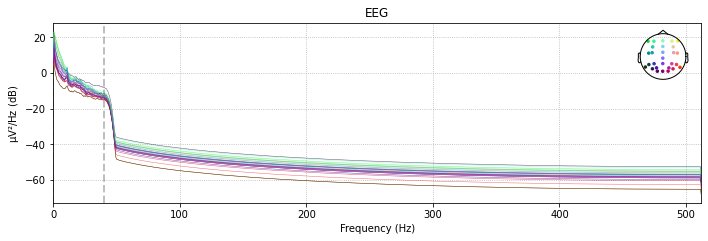

In [26]:
# filtered power spectral density (PSD)
raw_filtered.plot_psd(spatial_colors=True);

Opening raw-browser...


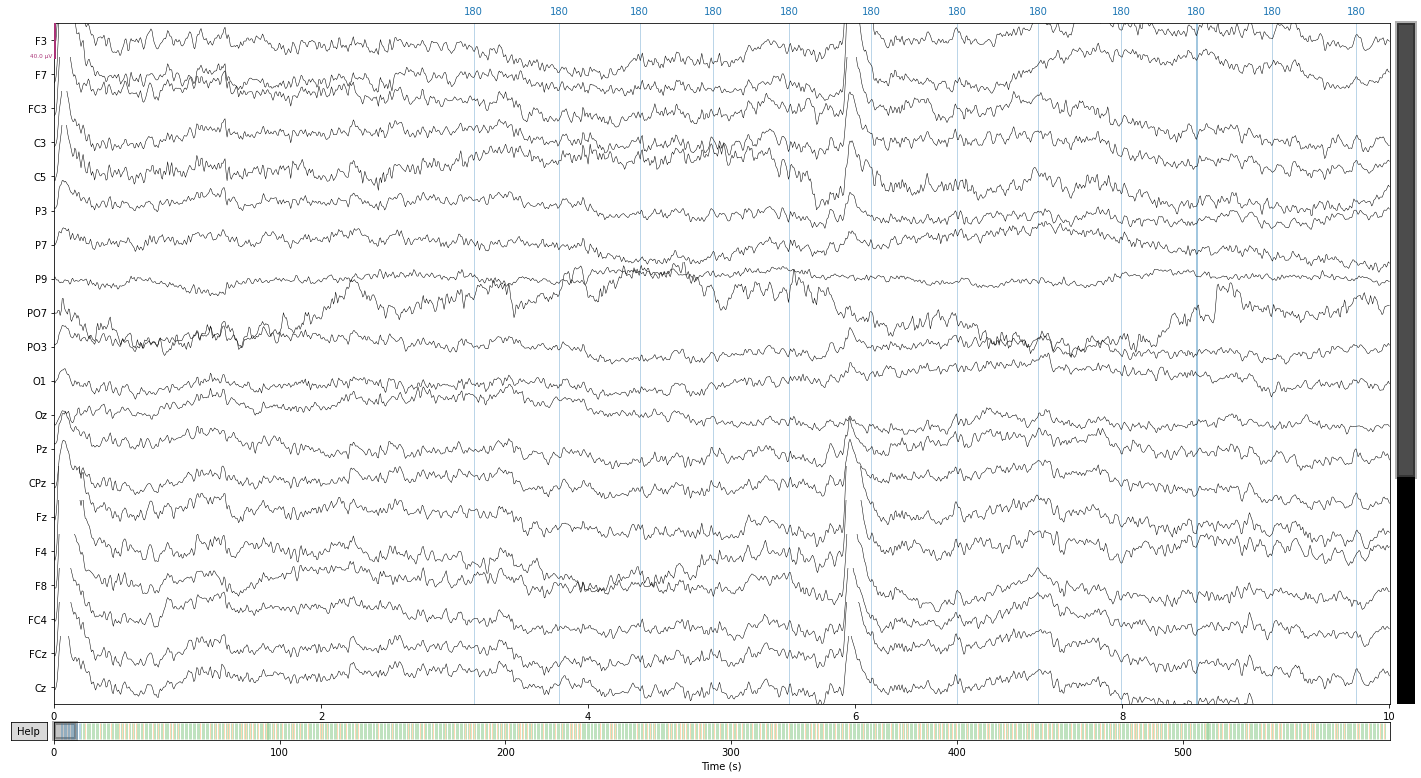

In [27]:
# and let's look at our raw data again
raw_filtered.plot();

In [28]:
# to free up space we can now delete the unfiltered raw data
del raw

<br/>

### Next  we'll identify noisy channels

Therefore we calculate the median absolute deviation of the signal in each channel compared to the others and reject channel that exceed a certain deviation threshold.

In [29]:
channel = raw_filtered.copy().pick_types(eeg=True).info['ch_names']  # get list of eeg channel names
data_ = raw_filtered.copy().pick_types(eeg=True).get_data() * 1e6  # * 1e6 to transform to microvolt

# calculate median absolute deviation for each channel
mad_scores =[scipy.stats.median_abs_deviation(data_[i, :], scale=1) for i in range(data_.shape[0])]

# compute z-scores for each channel
z_scores = 0.6745 * (mad_scores - np.nanmedian(mad_scores)) / scipy.stats.median_abs_deviation(mad_scores, 
                                                                                                scale=1)
# 1/1.4826=0.6745 (scale factor for MAD for non-normal distribution) 
#(check-ot https://cloudxlab.com/assessment/displayslide/6286/robust-z-score-method) for more info

print(z_scores)
# get channel containing outliers 
bad_dev = [channel[i] for i in np.where(np.abs(z_scores) >= 3.0)[0]]
print(bad_dev)

[ 0.58005334 -0.2317003   0.75274924  0.72205005  0.10069685  1.31877886
 -0.94839356 -2.07923514  2.4927019  -0.72200792 -0.62699208 -0.3022347
 -0.04730808  0.97145483  0.61868681 -0.32109764  0.35154143  0.04730808
 -0.13948393  1.84008387  1.49248066  0.99984965  0.56107756 -1.37281023
 -2.07923514 -0.74380373 -0.04888708 -0.42563546]
[]


<br/>

Now we could add the detected bad channels to the info objects; from now on they will be automatically regarded as such for further analysis; as there are no deviant channels found for this subject consult the tutorial on artifact detection in the preprocessing chapter of this book.

In [30]:
raw_filtered.info['bads'] = bad_dev 
raw_filtered.info['bads']

[]

In [31]:
raw_filtered.info  # take a lool at the "Bad channels" row

<Info | 9 non-empty values
 bads: []
 ch_names: F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, Fz, ...
 chs: 28 EEG, 2 EOG
 custom_ref_applied: True
 dig: 31 items (3 Cardinal, 28 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 30
 projs: []
 sfreq: 1024.0 Hz
>

<br/>
If we know which channels are problematic, we can estimate their actual signal levels given the surrounding electrodes via interpolation. As there we're no noisy channel identified given our outlier criteria, we'll skip this step.

In [32]:
#raw_filtered.interpolate_bads()

In [33]:
#raw_filtered.plot()

<br/>

### Next up we'll be dealing with artfifacts produced by eye-movement (i.e. blinking)

Mne has a dedicated function for finding blinks in the eeg data see <a href="https://mne.tools/stable/generated/mne.preprocessing.create_eog_epochs.html" title="MNE API: create_eog_epochs"> create_eog_epochs() </a> and <a href="https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html" title="MNE API: find_eog_events"> find_eog_events() </a>, which we'll use to illustrate the mean wave-form of blinks in our data.

Using EOG channels: VEOG, HEOG
EOG channel index for this subject is: [28 29]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 162 significant peaks
Number of EOG events detected: 162
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 162 events and 1025 original time points ...
1 bad epochs dropped
Not setting metadata
161 matching events foun

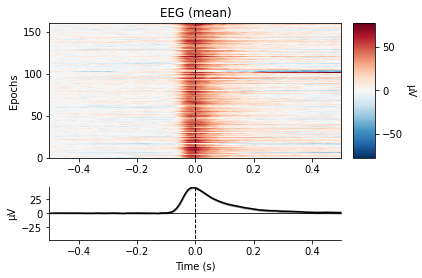

No projector specified for this dataset. Please consider the method self.add_proj.


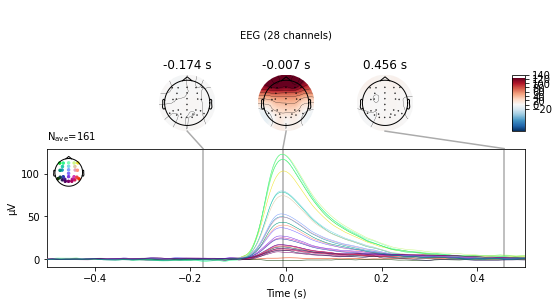

In [34]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_filtered, baseline=(-0.5, -0.5))
eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint();

<br/>

**We see a large change in mean amplitude in frontal regions, which slowly tapers with decreasing proximity to the eyes. Also take note of the peak amplitude ot these potentials and compare them to the amplitude of our actual evoked potentials later on.**

<br/>

### ICA for occular artifacts

**One of the most common and effetive tools for artifact detection, removal and repair is the Independent component analysis, which we'll use to exclude our occular artifacts from the data in the next step**

In brief:
ICA is a technique for signal processing that separates a signal into a specified number of linearly mixed sources. For the preprocessing of EEG data this is  used to find statistically independet sources of signal variability present in our n_channel dimensional data. EEG artifacts are usually strong sources of variability as they show higher amplitude than would be expected for sources of neural activity and generally appear more consistent than fluctuating neural activity, best illustrated by occular artifacts, and can therefore be easily identified via ICA.

**An ICA is performed in multiply steps:**

1. Specify the ICA algorithm/paramertes:

2. Fit the ICA to the data/Identify ICA components

3. Specify which components should be removed from the data

4. Reconstructing the Signal, i.e. apply the ICA solution with the components containing artifacts excluded to the data


**1. Specify the ICA algorithm/paramertes:**

In [35]:
# important to specify random seed (random_state) to reproduce the solution
ica = mne.preprocessing.ICA(n_components=15,
                            random_state=7,
                            max_iter='auto', 
                            method='infomax')  # set-up ICA parameters

<br/>

**2. Fit the ICA to the data/Identify ICA components**

In [36]:
ica.fit(raw_filtered)  # fit the ICA to our datab

Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by number: 15 components
 
Fitting ICA took 46.6s.


<ICA | raw data decomposition, method: infomax (fit in 500 iterations on 605849 samples), 15 ICA components explaining 95.5 % of variance (28 PCA components available), channel types: eeg, no sources marked for exclusion>

<br/>

**3. Specify which components should be removed from the data**

For artifact identification we plot our ica components as a topographic mapping.

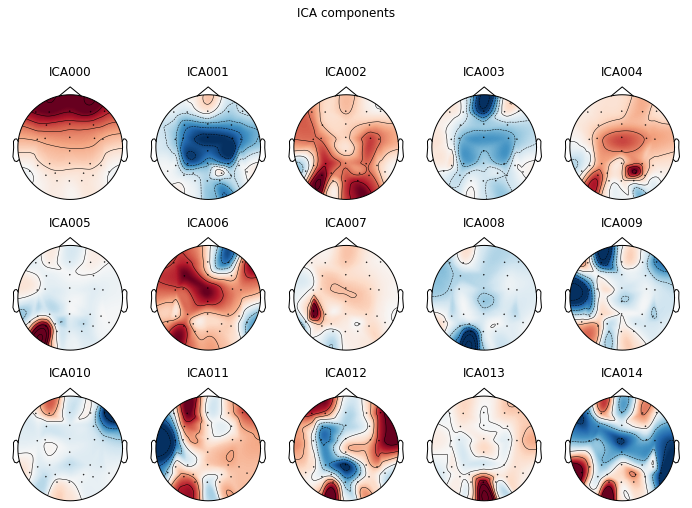

In [37]:
ica.plot_components(picks=range(0, 15));  # visualize our components

<br/>

We can also visualize components in source space, i.e. how the components represent latent sources over time
see <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_sources" title="MNE API: plot_sources()">MNE API: plot_sources() </a> for more info.

Creating RawArray with float64 data, n_channels=17, n_times=605849
    Range : 10599 ... 616447 =     10.351 ...   601.999 secs
Ready.
Opening ica-browser...


/tmp/ipykernel_30737/1459906232.py:1: RuntimeWarning: Omitted 14 annotation(s) that were outside data range.
  ica.plot_sources(raw_filtered);


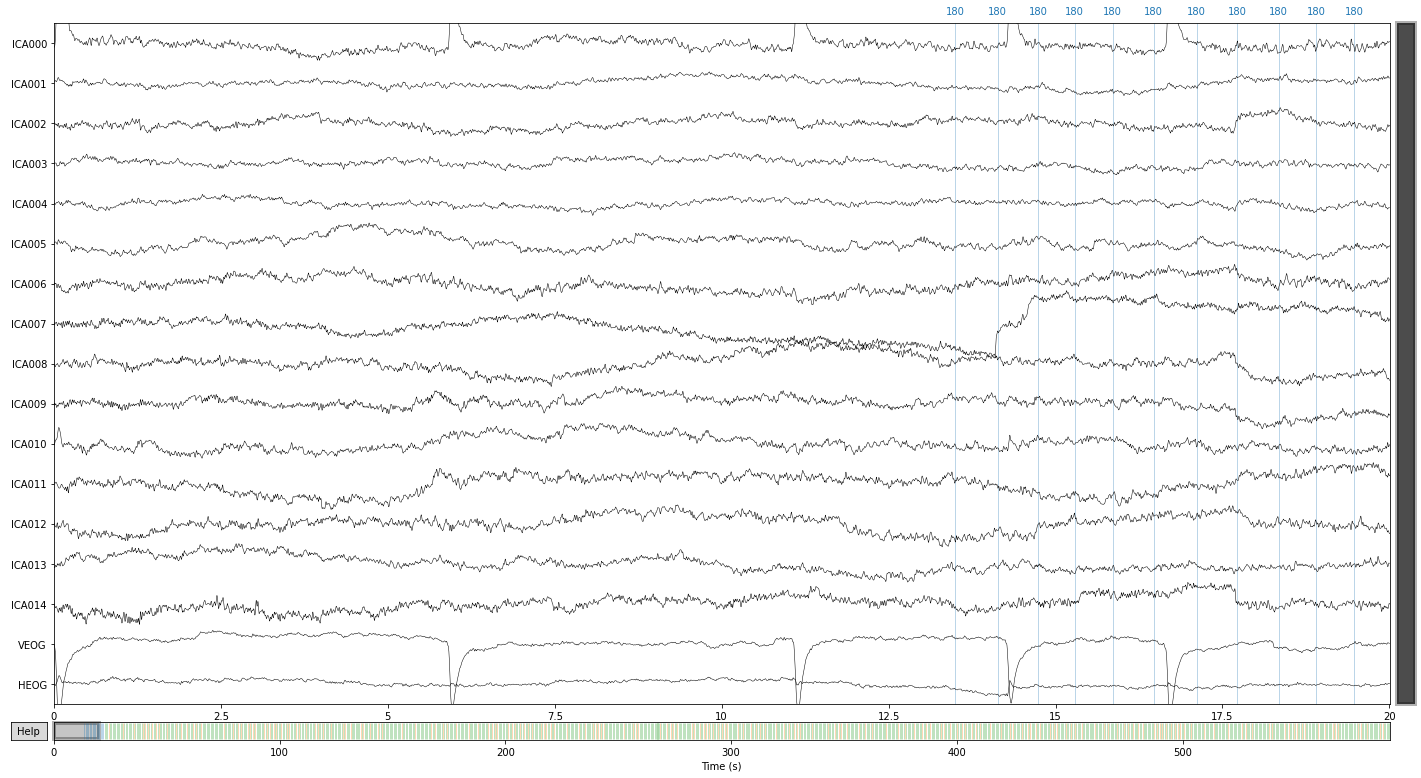

In [38]:
ica.plot_sources(raw_filtered);

<br/>

**We can further visualize what happens to our signal, if we were to extract certain components**

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 28 PCA components


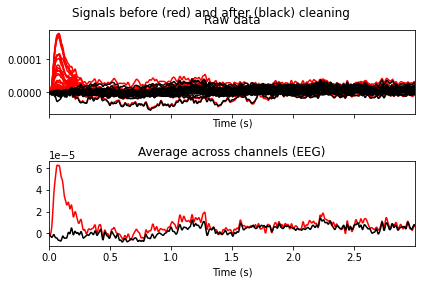

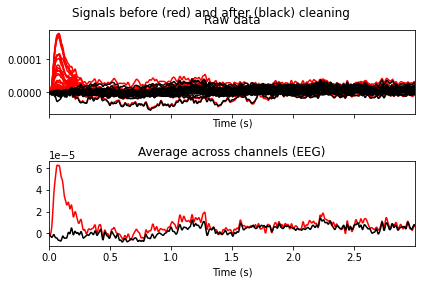

In [39]:
#ica.plot_overlay(raw_filtered, exclude=[0, 5, 10, 11, 13, 15, 18])
ica.plot_overlay(raw_filtered, exclude=[0, 6, 7, 8, 9, 11])

<br/>

Looks like we've gotten rid of blink artifacts, if we'd exclude the specified ICA components. So now we'll **add the components we want to exclude from our data to the ica.exlude object, create a copy of our filtered data and apply the ica solution**.

In [40]:
# apply ica with automaticaly excluded component
ica.exclude = [0, 6, 7, 8, 9, 11]

reconst_sig = raw_filtered.copy().pick_types(eeg=True, exclude='bads')

<br/>

**4. Reconstructing the Signal**

In [41]:
ica.apply(reconst_sig)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 28 PCA components


<RawEEGLAB | sub-021_task-MMN_eeg.fdt, 28 x 605849 (591.6 s), ~129.5 MB, data loaded>

<br/>

Let's compare our ICA reconstructed signal to the filtered data

Opening raw-browser...


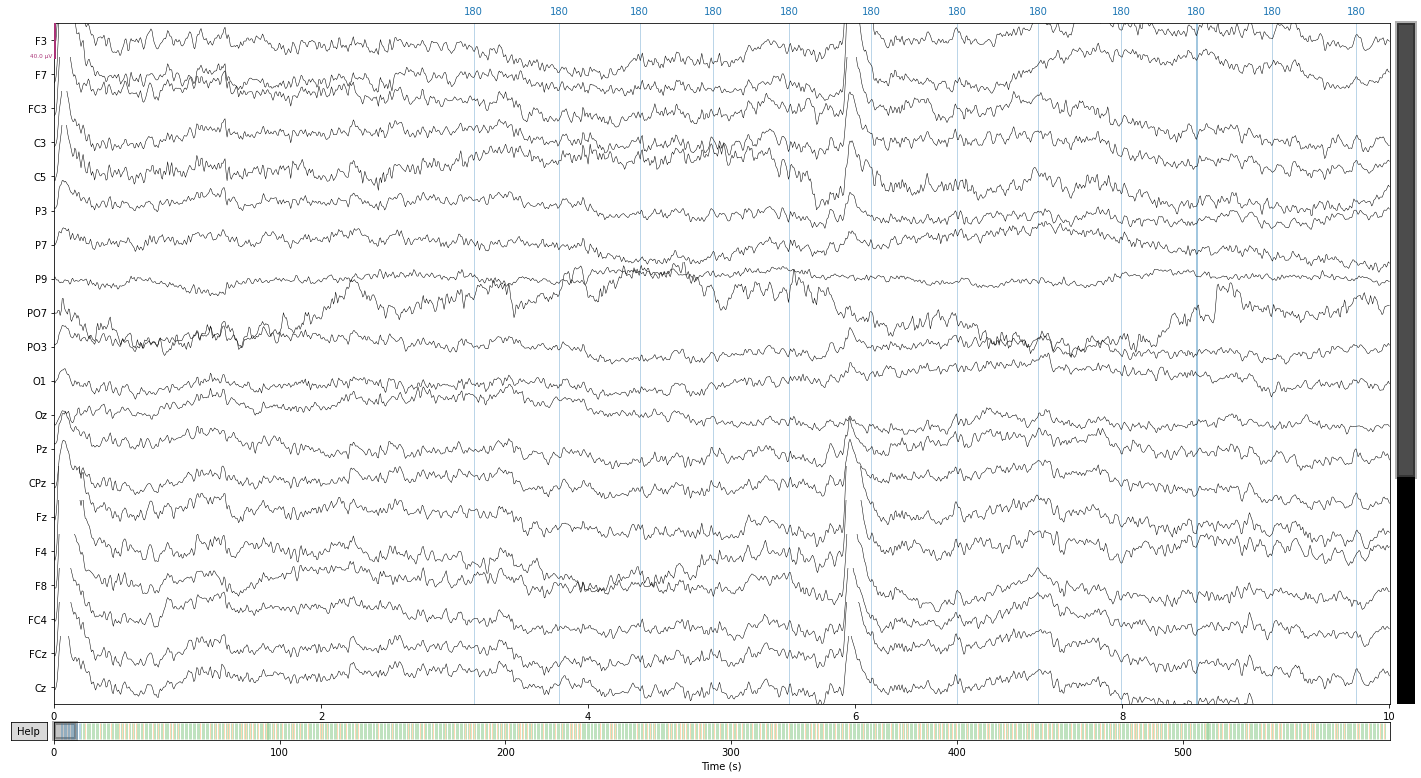

In [42]:
raw_filtered.plot();

Opening raw-browser...


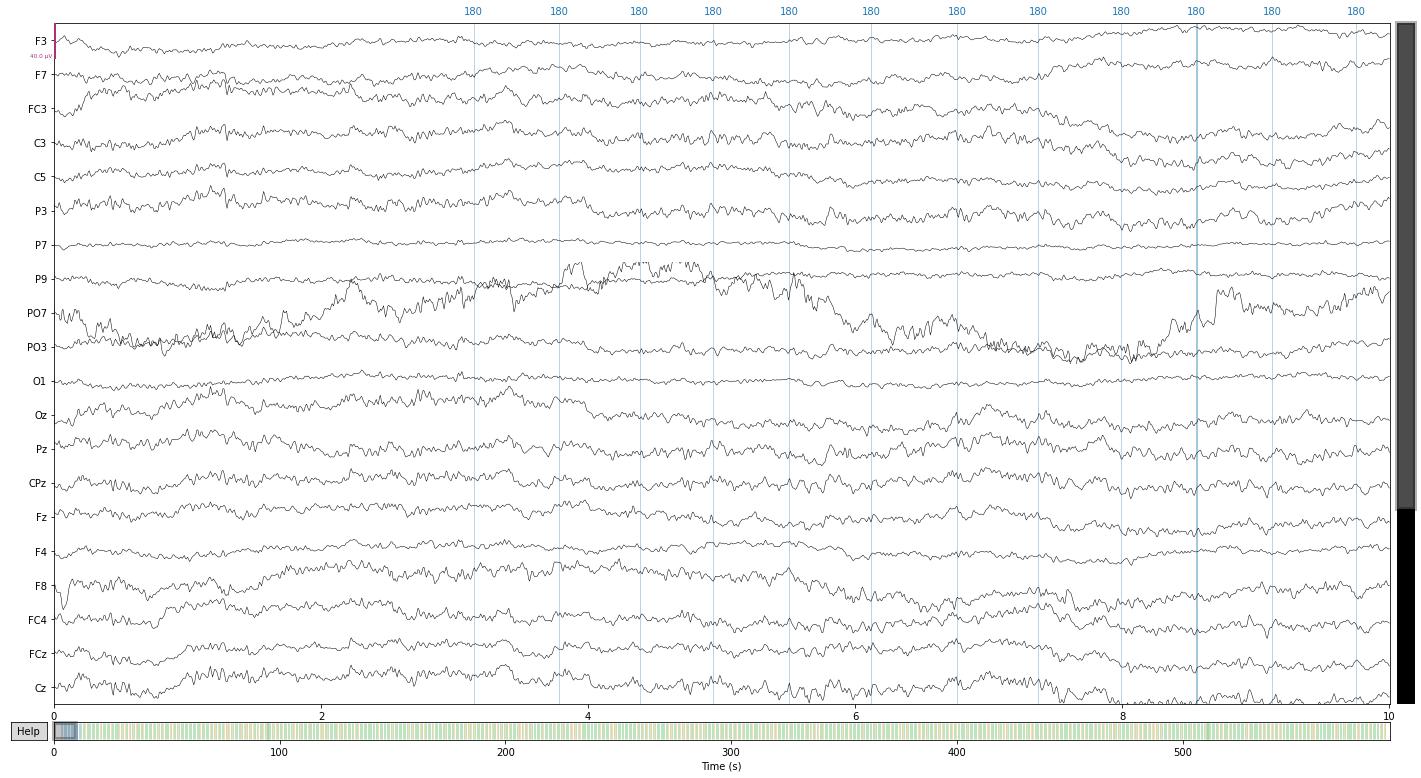

In [43]:
reconst_sig.plot();

<br/>

PO7 still look problematic so let's exlcude it

In [44]:
reconst_sig.info['bads'] = ['PO7']

<br/>

### Epoching

To calculate evoked potentials it's necessary to divide our continous data into segements centered around the presentation of our stimuli, so called epochs.
- therefore we'll have to **find our events and find out how our stimuli are encoded**
- further we'll need to **specify the time-frame of our epochs**, centered around our stimuls

In [45]:
# let's see what the event file can tell us
event_file

onset  duration  sample trial_type  stim_file  value
0      10.3506       NaN   10600     STATUS        NaN      1
1      13.4941       0.1   13819   stimulus        NaN    180
2      14.1328       0.1   14473   stimulus        NaN    180
3      14.7363       0.1   15091   stimulus        NaN    180
4      15.2861       0.1   15654   stimulus        NaN    180
...        ...       ...     ...        ...        ...    ...
996   597.5869       0.1  611930   stimulus        NaN     70
997   598.1875       0.1  612545   stimulus        NaN     80
998   598.7471       0.1  613118   stimulus        NaN     80
999   599.3535       0.1  613739   stimulus        NaN     70
1000  599.9307       0.1  614330   stimulus        NaN     80

[1001 rows x 6 columns]

<br/>

using the  <a href="https://mne.tools/stable/generated/mne.events_from_annotations.html" title="MNE API: mne.events_from_annotations()">mne.events_from_annotations() </a> function, we can see that the eeg data already contains the necessary information regarding events, although they are merely numerically coded.

In [46]:
events_from_annot, event_dict = mne.events_from_annotations(reconst_sig)

Used Annotations descriptions: ['180', '70', '80']


<br/>

the <a href="https://mne.tools/stable/generated/mne.events_from_annotations.html" title="MNE API: mne.events_from_annotations()">mne.events_from_annotations() </a> returns two variables: 

- an np.array containing the sample at which an event occured in the first column and the identifier of the event in the last column

In [47]:
events_from_annot

array([[ 13818,      0,      1],
       [ 14472,      0,      1],
       [ 15090,      0,      1],
       ...,
       [613117,      0,      3],
       [613738,      0,      2],
       [614329,      0,      3]])

<br/>

- and an dictionary containing the event code corresponding to the event identifier in the events array

In [48]:
event_dict

{'180': 1, '70': 2, '80': 3}

<br/>

with the <a href="https://mne.tools/stable/generated/mne.viz.plot_events.html" title="MNE API: plot_events()">plot_events()</a>  function we'll visualize our events in the time domain

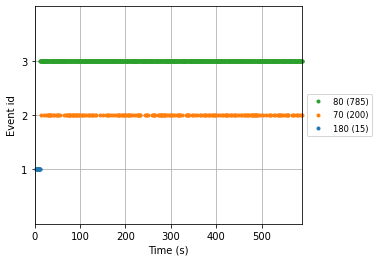

In [49]:
mne.viz.plot_events(events_from_annot, reconst_sig.info['sfreq'], reconst_sig.first_samp,
                    event_id=event_dict);

<br/>

**Given this information we can finally create our epochs object using the <a href="https://mne.tools/stable/generated/mne.Epochs.html" title="MNE API: mne.Epochs()">mne.Epochs()</a> constructor**.

For more info on the Epochs data structure see the <a href="https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html#sphx-glr-auto-tutorials-epochs-10-epochs-overview-py" title="MNE tutorial: The Epochs data structure: discontinuous data)">MNE tutorial: The Epochs data structure: discontinuous data</a>. Baseline correction will be automatically applied given the intervall between tmin (epoch start) and t = 0 (i.e. the relevant event) of specified epochs, but can be specified by adding the baseline parameter to the mne.Epochs() constructor.

In [50]:
baseline = (-0.2, 0)  # would default to this, but let's be explicit
epochs = mne.Epochs(reconst_sig,
                    events_from_annot, picks=['eeg'], tmin=-0.2, tmax=0.8,
                    preload=True, baseline=baseline)

Not setting metadata
1000 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1000 events and 1025 original time points ...
0 bad epochs dropped


Opening epochs-browser...


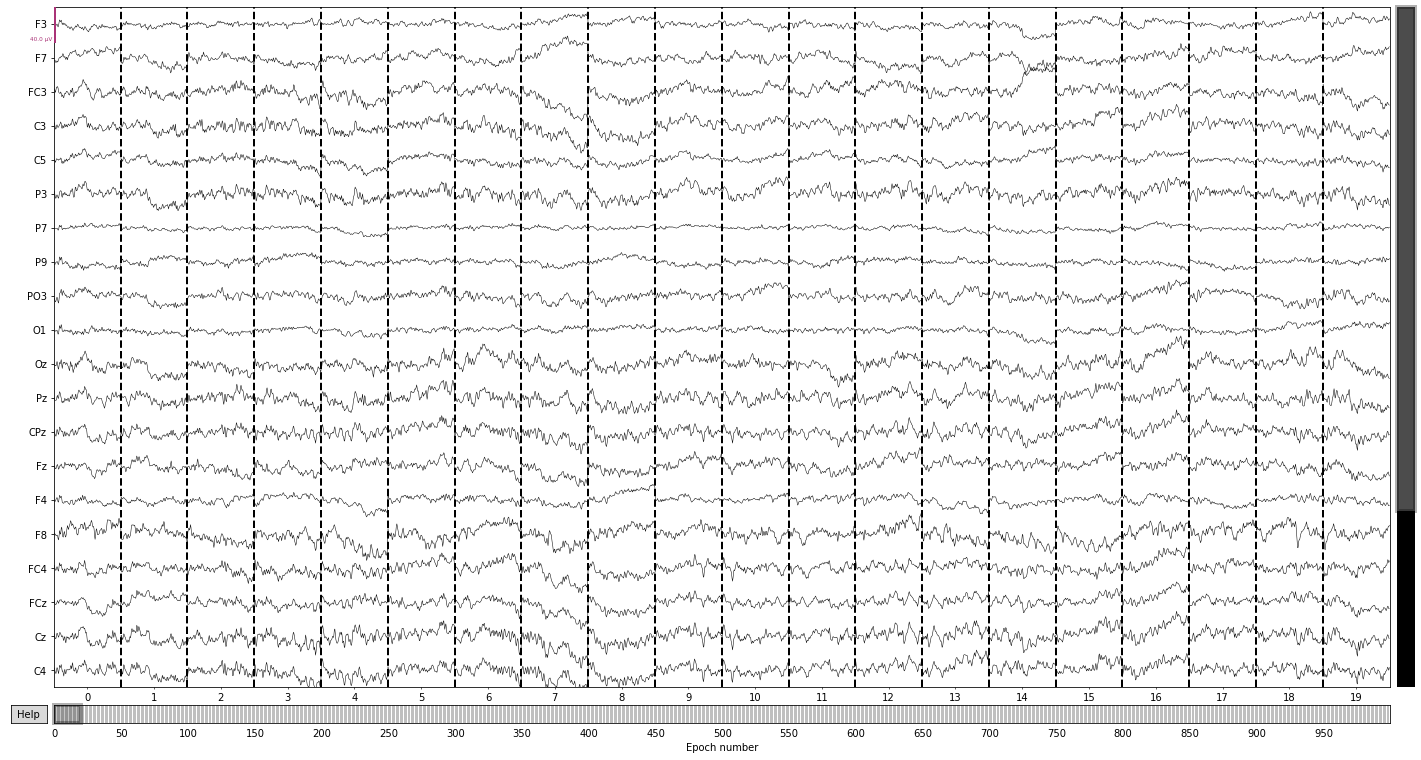

In [51]:
epochs.plot();  # we can also visualize our epochs via the plot() function

<br/>

Next we **reject eppochs by maximum/minimum peak-to-peak signal value thresholds** (exceeding 100 µV, as it's highly unlikely that any eeg-signal may reach this amplitude, or epochs with channel with signal below 1 µV to get rid of flat channels) using the <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.drop_bad" title="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.drop_bad">epochs.drop_bad()</a> function.

In [52]:
# define upper and lower threshold as dict(channel_type:criteria)
reject_criteria_upper = dict(eeg=100e-6)  # 100 µV
reject_criteria_flat = dict(eeg=1e-6)  # 1 µV
epochs.drop_bad(reject=reject_criteria_upper, flat=reject_criteria_flat)

    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
12 bad epochs dropped


<Epochs |  988 events (all good), -0.200195 - 0.799805 sec, baseline -0.2 – 0 sec, ~216.4 MB, data loaded,
 '1': 15
 '2': 198
 '3': 775>

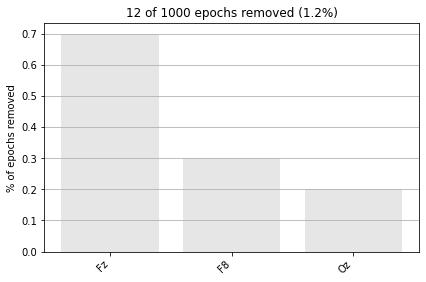

In [53]:
# visualize how many and based on what values in what channels epochs were dropped
epochs.plot_drop_log();

In [54]:
event_dict  # let's recall our event codes and identfiers

{'180': 1, '70': 2, '80': 3}

<br/>

Using the **information in the readme.md provided by the authors** (and a bit of common sense) we can assign meaningful names to our events; The event id 2 appearing 200 times implies that this is our **oddball** (check the events plot above), while the event-id 3 appearing ~ 800 times implies that this is our **standard tone**. The 180 encodes the first 15 standard tones.

In [55]:
# let's write up our new event_dict
event_conditions_dict = {'first_15_standards': 1, 'deviant': 2, 'standard': 3}

In [56]:
epochs.event_id = event_conditions_dict  # add our event dict to the epochs object
print(epochs.event_id) 
print(epochs)

{'first_15_standards': 1, 'deviant': 2, 'standard': 3}
<Epochs |  988 events (all good), -0.200195 - 0.799805 sec, baseline -0.2 – 0 sec, ~216.4 MB, data loaded,
 'first_15_standards': 15
 'deviant': 198
 'standard': 775>


<br/>
Now we can access subtyes (i.e. deviant and standard) of our epochs based on these labels

Opening epochs-browser...


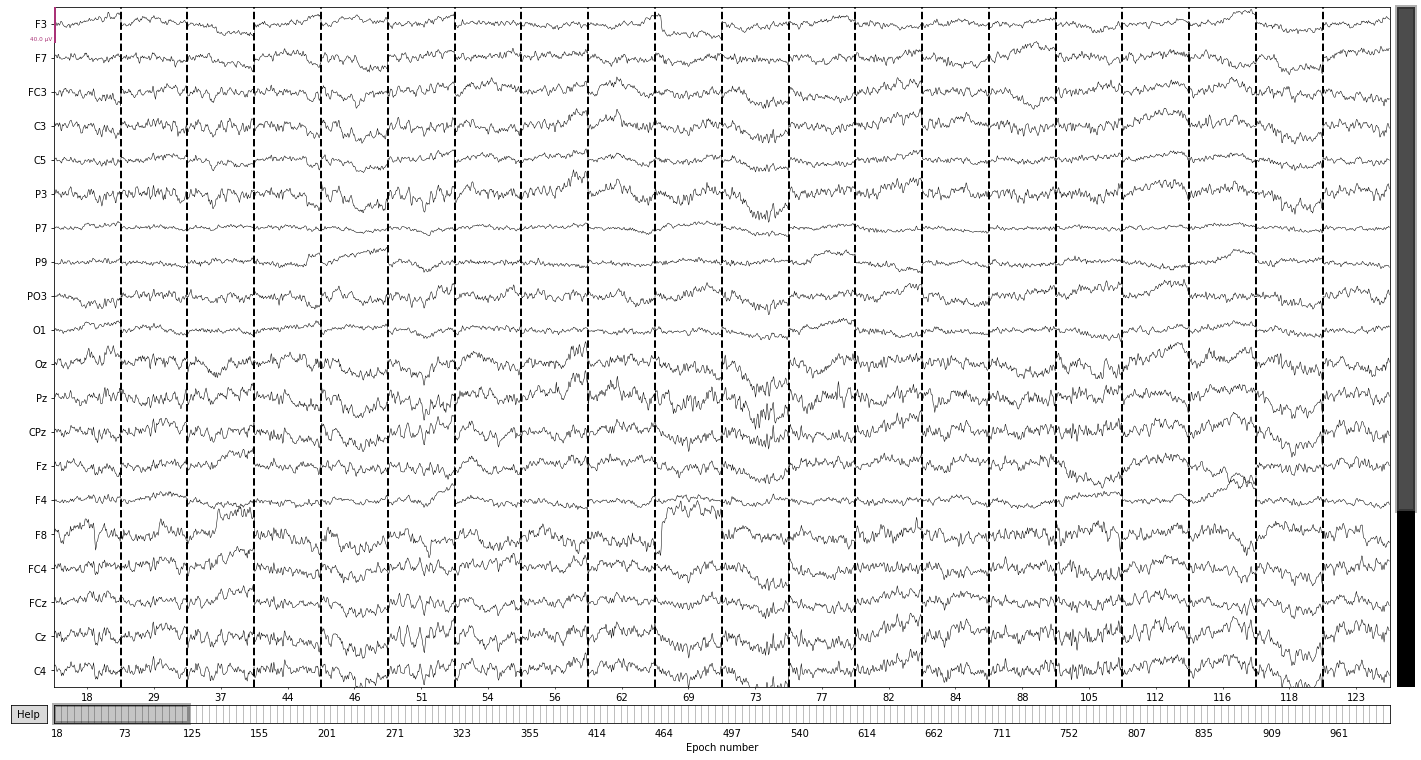

In [57]:
epochs['deviant'].plot();  # epochs centered around presentation of deviant tones

<br/>

## 3. Calculate evoked potentials/MMN

To calculate our evoked potentials we simply **average over all epochs based on the respective conditions**. We'll apply the <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.average" title="MNE API: epochs.avergae()">epochs.avergae()</a> to the deviant and the standard tones epochs separately.

In [58]:
deviant_tone = epochs['deviant'].average()

In [59]:
standard_tone = epochs['standard'].average()

In [60]:
# let's see what's in the specific epoch objects
epochs['deviant']

<Epochs |  198 events (all good), -0.200195 - 0.799805 sec, baseline -0.2 – 0 sec, ~43.4 MB, data loaded,
 'deviant': 198>

In [61]:
epochs['standard']

<Epochs |  775 events (all good), -0.200195 - 0.799805 sec, baseline -0.2 – 0 sec, ~169.7 MB, data loaded,
 'standard': 775>

<br/>

**Next we can visualize the average activity in each channel with the <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_joint" title="MNE API: evoked.plot_joint()">evoked.plot_joint()</a> function**

No projector specified for this dataset. Please consider the method self.add_proj.


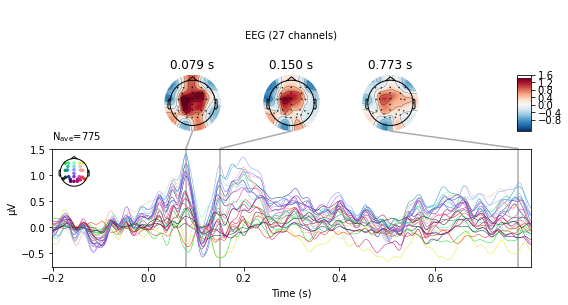

In [62]:
standard_tone.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


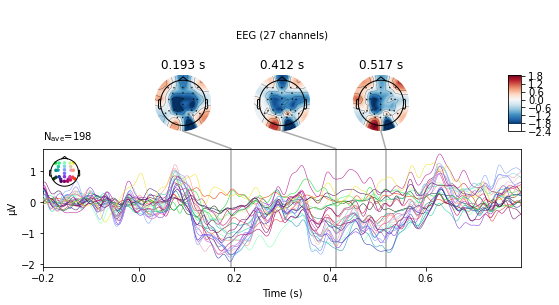

In [63]:
deviant_tone.plot_joint();

<br/>
The <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_joint" title="MNE API: evoked.plot_joint()">evoked.plot_joint()</a> function picks the most extreme events to plot as topomaps, to actually specify time-points of interest use the <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_topomap" title="MNE API: evoked.plot_topomap()">evoked.plot_topomap()</a> function

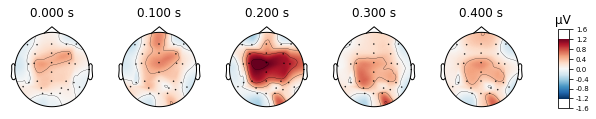

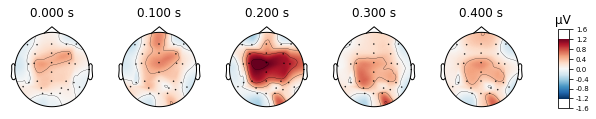

In [64]:
standard_tone.plot_topomap(times=[0, 0.1, 0.2, 0.3, 0.4], average=0.05)

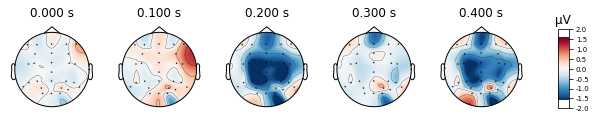

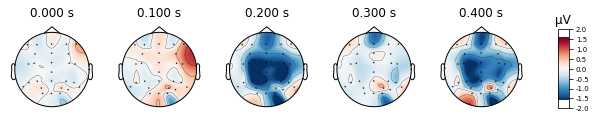

In [65]:
deviant_tone.plot_topomap(times=[0, 0.1, 0.2, 0.3, 0.4], average=0.05)

<br/>

We can also **visualize a selection of channels by using the picks argument**. We'll look at fronto-central electrodes as they are of interest for detection of deviant stimuli.

No projector specified for this dataset. Please consider the method self.add_proj.


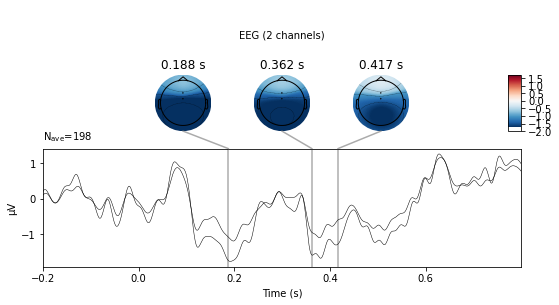

In [66]:
deviant_tone.plot_joint(picks=['Cz', 'FCz'], ts_args=dict(spatial_colors=False));

No projector specified for this dataset. Please consider the method self.add_proj.


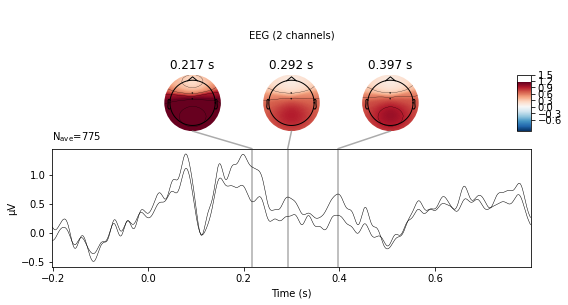

In [67]:
standard_tone.plot_joint(picks=['Cz', 'FCz'],ts_args=dict(spatial_colors=False));

<br/>

We can also plot the evoked data as an image plot using the <a href="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_image" title="https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_image">.plot_image()</a> function, which returns a heatmap that reflects the amplitude of the average signal for each channel in the picks parameter (which defaults to all, if not explicitly instructed otherwise) over the epoch.

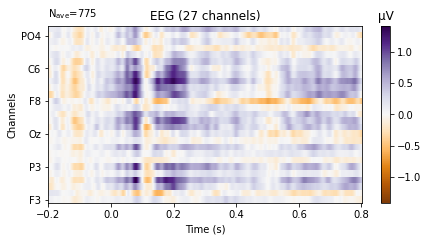

In [68]:
standard_tone.plot_image(picks='eeg',
                  show_names=True,  # would be much more informative if sample_data followed classic nomenclature
                  cmap='PuOr');

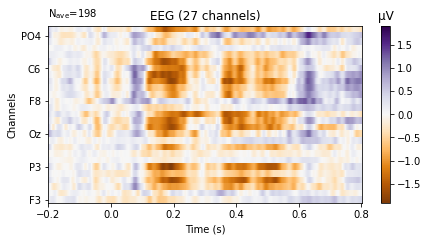

In [69]:
deviant_tone.plot_image(picks='eeg',
                  show_names=True,  # would be much more informative if sample_data followed classic nomenclature
                  cmap='PuOr');

<br/>

**To directly compare evoked potentials we can also use the <a href="https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html" title="MNE API: evoked.plot_compare_evokeds()">evoked.plot_compare_evokeds()</a> function, which gives us a few more options to style our plots.**

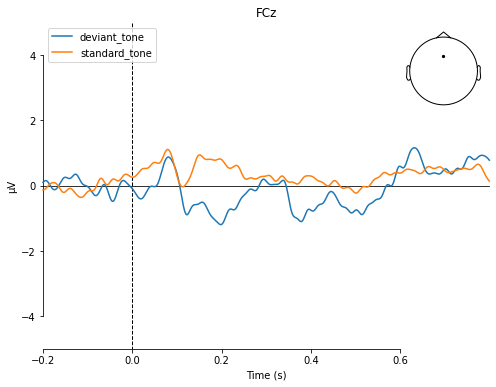

[<Figure size 576x432 with 2 Axes>]

In [70]:
mne.viz.plot_compare_evokeds(dict(deviant_tone=deviant_tone,
                                    standard_tone=standard_tone),
                               picks='FCz', title='FCz',
                               ylim=dict(eeg=[-5, 5]))

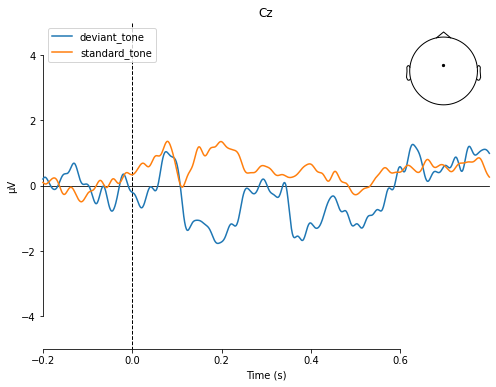

[<Figure size 576x432 with 2 Axes>]

In [71]:
mne.viz.plot_compare_evokeds(dict(deviant_tone=deviant_tone,
                                    standard_tone=standard_tone),
                               picks='Cz', title='Cz',
                               ylim=dict(eeg=[-5, 5]))

<br/>

### Calculate the MMN

Next we calculate the MMM by **substracting the evoked potential of the standard tone from the evoked potential of the deviant tone** using the  <a href="https://mne.tools/stable/generated/mne.combine_evoked.html#mne.combine_evoked" title="MNE API: mne.combine_evoked.()">mne.combine_evoked.()</a> function. Subtraction is performed by setting the weights argument  = [1, -1]

To recall the MMN should peak at about 100–250 ms after change onset, with at most a -5 μV maximum peak {cite:p}`garrido_mismatch_2009`.

Need more than one channel to make topography for eeg. Disabling interactivity.


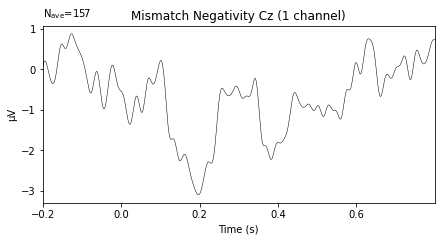

In [72]:
mmn = mne.combine_evoked([deviant_tone, standard_tone],
                         weights=[1, -1])
mmn.plot(picks=['Cz'], titles='Mismatch Negativity Cz');

<br/>

Looks plausible, but given time/effort and data from more subjects (i.e. calculating a grand average MMN) would probably produce a less noisy wave-form. I'd also advise to further style the plot using <a href="https://matplotlib.org/stable/tutorials/index" title="https://matplotlib.org/stable/tutorials/index">matplotlib</a>.

<br/>

## 4. Save Data

### Now we can export our epochs data in a number of ways for further analysis

**To save it as an epochs object use the  <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.save" title="MNE API: mne.Epochs.save()"> epochs.save() </a> function**
- we'll be using the mne standard for eeg data, i.e. .fif format

In [73]:
epochs.save(sub_21_eeg_path + str(os.sep) + 'sub-21_mmn_epochs.fif', overwrite=True)

/tmp/ipykernel_30737/725490711.py:1: RuntimeWarning: This filename (/home/michael/msc_05_eeg_workflow/sub-21/eeg/sub-21_mmn_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(sub_21_eeg_path + str(os.sep) + 'sub-21_mmn_epochs.fif', overwrite=True)


<br/>

**For more complex plotting or statistical analysis, we can further export the data in long-format to a pandas DataFrame and save the created DataFrame as a tsv file**
- for more info on how to specify the structure and composition of the DataFrame see <a href="https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.to_data_frame" title="MNE API: mne.Epochs.to_data_frame()"> epochs.to_data_frame() </a> 
- for more info on how to specify your csv/tsv see <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html" title="pandas.DataFrame.to_csv()"> pd.DataFrame.to_csv() </a>
    - be sure to keep your index or convert the index to a column


In [74]:
epochs_df = epochs.to_data_frame(index=['condition', 'epoch', 'time'])

In [75]:
epochs_df.to_csv(sub_21_eeg_path + str(os.sep) + 'sub-21_mmn_epochs.tsv', sep='\t')

<br/>

**To save our MMN figure we can use the <a href="https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.savefig.html" title="https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.savefig.html"> matplotlib.plt.savefig()</a> function**

Need more than one channel to make topography for eeg. Disabling interactivity.


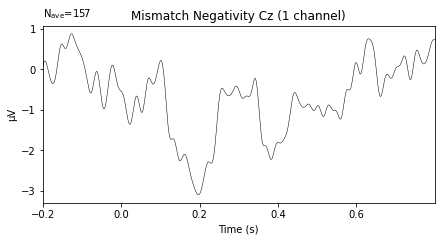

In [76]:
fig = mmn.plot(picks=['Cz'], titles='Mismatch Negativity Cz');
fig.savefig(derivatives_path + str(os.sep) + 'sub-21_mmn_cz.png')

## References

```{bibliography}
:filter: docname in docnames
:style: plain
```